# Motion Recognition with SNNs
## Imports

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import snntorch as snn

from utils import create_sample, make_event_based, animate, spiking_overview

## Set Variables

In [2]:
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
frame_size = 64
n_frames = 32

## Visualize Data

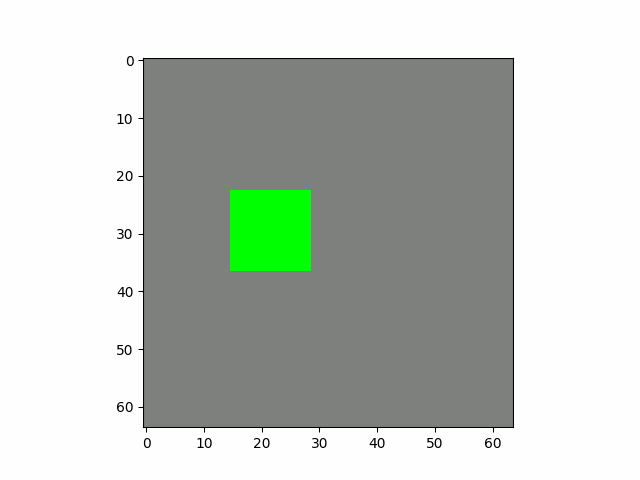

In [8]:
# Create a sample
shape = "square"
motion = "rotation"
frames, label = create_sample(shape, motion, frame_size, n_frames)
animate(frames, filename=f"{shape}_{motion}_frames.gif")

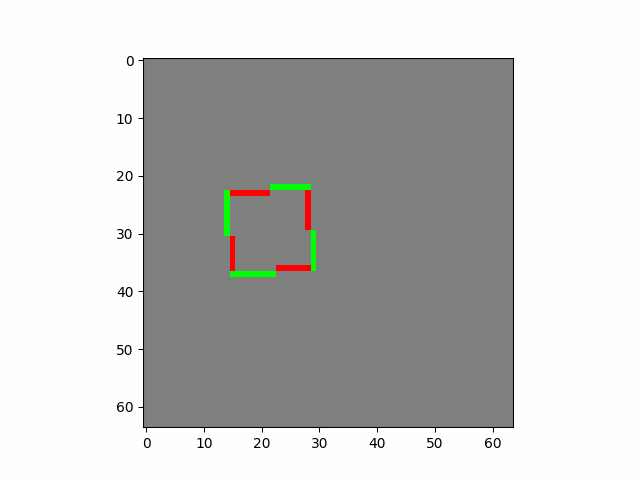

In [9]:
events = make_event_based(frames)
animate(events, filename=f"{shape}_{motion}_events.gif")

## Dataset

In [12]:
class EventBasedDataset(Dataset):
    def __init__(self, samples, frame_size, n_frames):
        self.samples = samples
        self.frame_size = frame_size
        self.n_frames = n_frames

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        shape = np.random.choice(["circle", "square"])
        motion = np.random.choice(["up", "down", "left", "right", "rotation"])
        frames, label = create_sample(shape, motion, self.frame_size, self.n_frames)
        events = make_event_based(frames)
        return torch.from_numpy(events).type(torch.float32), torch.tensor(label, dtype=torch.long)

# Create a dataset
train_dataset = EventBasedDataset(10000, frame_size, n_frames)
test_dataset = EventBasedDataset(1000, frame_size, n_frames)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding="same")
        self.lif1 = snn.Leaky(beta=0.95)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding="same")
        self.lif2 = snn.Leaky(beta=0.95)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32*16*16, 5)
        self.lif3 = snn.Leaky(beta=0.95)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk1_rec = []
        mem1_rec = []

        spk2_rec = []
        mem2_rec = []

        spk3_rec = []
        mem3_rec = []

        # (B, T, H, W) -> (B, C, T, H, W) where C = 1
        if len(x.shape) == 4:
            x = x.unsqueeze(1)
            steps = x.shape[2]
        # (T, H, W) -> (B, C, T, H, W) where B = C = 1
        if len(x.shape) == 3:
            x = x.unsqueeze(0).unsqueeze(0)
            steps = x.shape[2]
        
        for step in range(steps):
            x_step = x[:, :, step]
            # print(x_step.shape)
            cur1 = self.conv1(x_step)
            spk1, mem1 = self.lif1(self.pool1(cur1), mem1)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(self.pool2(cur2), mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            cur3 = self.fc1(spk2.flatten(1))
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)

convnet = ConvNet().to(device)

## Train

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=1e-2, betas=(0.9, 0.999))

num_epochs = 2
loss_hist = []
test_loss_hist = []
counter = 0

for epoch in range(num_epochs):
    train_batch = iter(train_dataloader)

    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        convnet.train()
        optimizer.zero_grad()

        spk_rec, _, _, _, _, _ = convnet(data)
        loss_val = loss(spk_rec.sum(0), targets)
        loss_val.backward()
        optimizer.step()

        loss_hist.append(loss_val.item())

        if counter % 10 == 0:
            print(f"Epoch: {epoch}, Counter: {counter}, Loss: {loss_val.item()}")

        counter += 1

## Load Model

In [14]:
# load model from .pth file
convnet.load_state_dict(torch.load('models/model-25_6k.pth', map_location=device))

<All keys matched successfully>

## Test

In [15]:
# shape = "square"
# motion = "rotation"
# frames, label = create_sample(shape, motion, frame_size, n_frames)
# events = make_event_based(frames)
spk3, mem3, spk2, mem2, spk1, mem1 = convnet(torch.from_numpy(events).type(torch.float32))
spks = [spk1.detach().numpy().squeeze(1), spk2.detach().numpy().squeeze(1), spk3.detach().numpy().squeeze(1)]

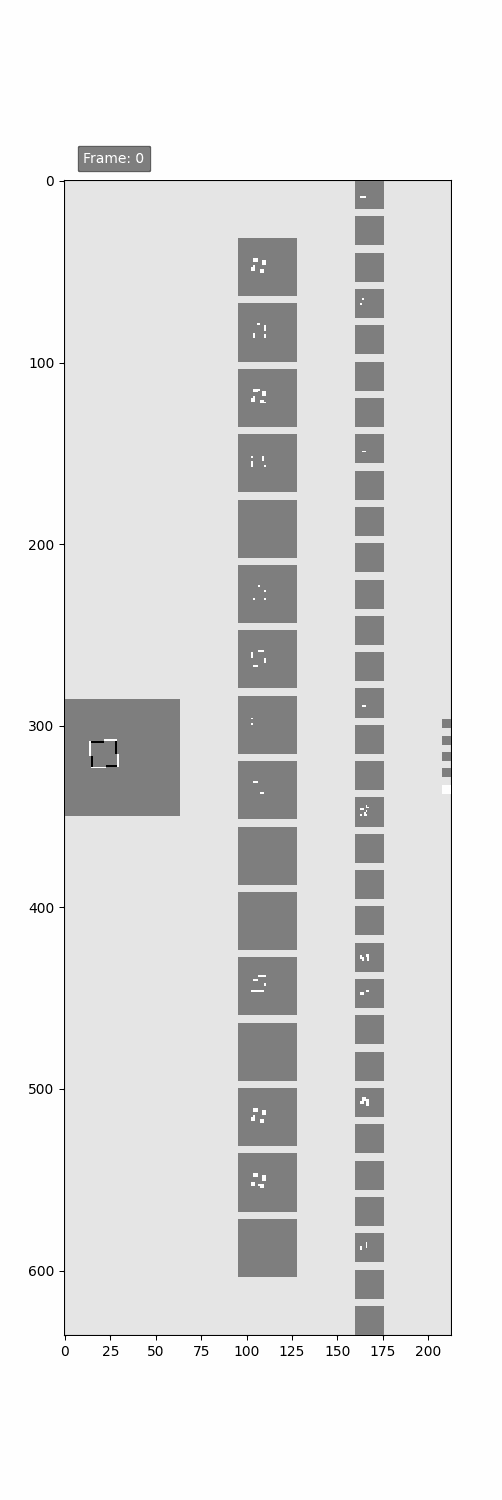

In [16]:
# Example usage
filename = 'spiking_overview'
spiking_overview(spks, events, frame_size, filename)